# Predikce pomocí ANN

In [1]:
import numpy as np
from neural_net.neuralnet import NeuralNet
import neural_net.activation_functions as af
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import json
import csv
from pylab import rcParams
import random
rcParams['figure.figsize'] = 16, 6 # resize figures
plt.style.use('bmh')

## Úvod
Tento projekt se pokouší predikovat vývoj veličiny avg temps na základě 5 proměnných, ze kterých není veličina přímo odvozená:
- Precipitation
- Insolation
- Evaporation
- AvgHumidity
- Windspeed

## Preprocessign dat

In [2]:
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    avg_temps = np.array([l['AvgTemp'] for l in reader])
    avg_temps = np.array([np.nan if l=='' else l for l in avg_temps], dtype='float64') # replace missing values with NaN
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    dates = np.array([l['Date'] for l in reader], dtype='int64') / 100_000 # squish the range of dates
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    inputs = np.array([[l['Precipitation'], l['Insolation'], l['Evaporation'], l['AvgHumidity'], l['WindSpeed']] for l in reader])
    inputs = np.where(inputs == '', np.nan, inputs)
    inputs = np.where(inputs == '#N/A', np.nan, inputs)
    inputs = inputs.astype('float64')
    
dates[0:5], avg_temps[0:5], inputs

(array([0.40179, 0.4018 , 0.40181, 0.40182, 0.40183]),
 array([27.14, 27.7 , 28.68, 26.4 , 24.98]),
 array([[ 0.      ,  9.5     ,  1.7     , 79.25    ,  1.666667],
        [ 0.      ,  8.7     ,  3.5     , 75.25    ,  1.      ],
        [ 0.      ,  8.3     ,  4.1     , 73.      ,  0.      ],
        ...,
        [ 5.8     ,  8.8     ,       nan, 92.      ,  1.02888 ],
        [ 0.      ,  0.2     ,       nan, 93.      ,  0.      ],
        [ 0.      ,  7.1     ,       nan, 97.      ,  0.      ]]))

Grafické znázornění časové řady

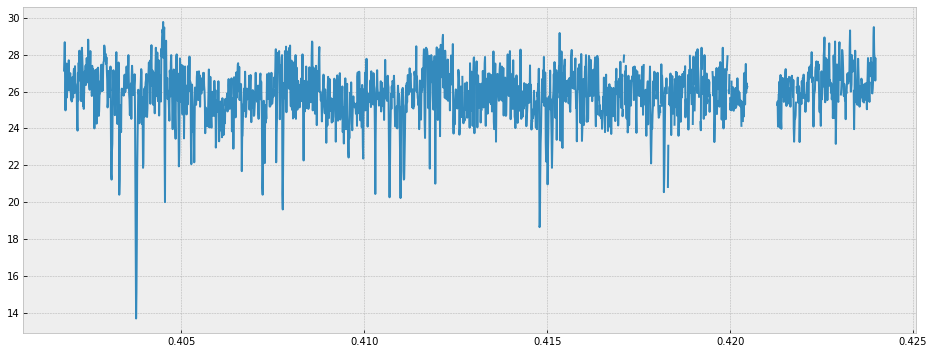

In [3]:
plt.plot(dates, avg_temps)

### Doplnění chybějících hodnot

Ověření předpokladu, že se jedná o časovou řadu

In [4]:
np.all(np.diff(dates) > 0)

True

Lineární interpolace chybějících dat výstupů, vypočtení popisné statistiky střední hodnota a rozptyl (pro 0 stupňů volnosti)

In [5]:
avg_temps_interp = NeuralNet.linear_interpolation(avg_temps)
np.mean(avg_temps_interp), np.var(avg_temps_interp)

(25.887502343017804, 1.9603880733830343)

In [6]:
len(inputs), len(avg_temps_interp)

(2134, 2134)

Aplikování normalizace, detrendování diferencí I. řádu. Chybějící data doplněna lineární interpolací

In [7]:
norm_avg_temps = NeuralNet.normalize(avg_temps_interp)
diff_norm_avg_temps = np.diff(norm_avg_temps)

inputs_interp = NeuralNet.linear_interpolation(inputs)
norm_inputs = NeuralNet.normalize(inputs_interp)
diff_norm_inputs = np.diff(norm_inputs, axis=0)

norm_inputs, diff_norm_inputs

(array([[0.        , 0.087236  , 0.01561065, 0.72773186, 0.01530456],
        [0.        , 0.07988981, 0.03213958, 0.69100092, 0.00918274],
        [0.        , 0.07621671, 0.03764922, 0.67033976, 0.        ],
        ...,
        [0.05325987, 0.08080808, 0.00944793, 0.84481175, 0.00944793],
        [0.        , 0.00183655, 0.        , 0.85399449, 0.        ],
        [0.        , 0.06519743, 0.        , 0.89072544, 0.        ]]),
 array([[ 0.        , -0.00734619,  0.01652893, -0.03673095, -0.00612183],
        [ 0.        , -0.00367309,  0.00550964, -0.02066116, -0.00918274],
        [ 0.04224059, -0.06336088, -0.00091827,  0.07805326,  0.00918274],
        ...,
        [ 0.05325987,  0.05785124,  0.00472397,  0.03673095,  0.00472397],
        [-0.05325987, -0.07897153, -0.00944793,  0.00918274, -0.00944793],
        [ 0.        ,  0.06336088,  0.        ,  0.03673095,  0.        ]]))

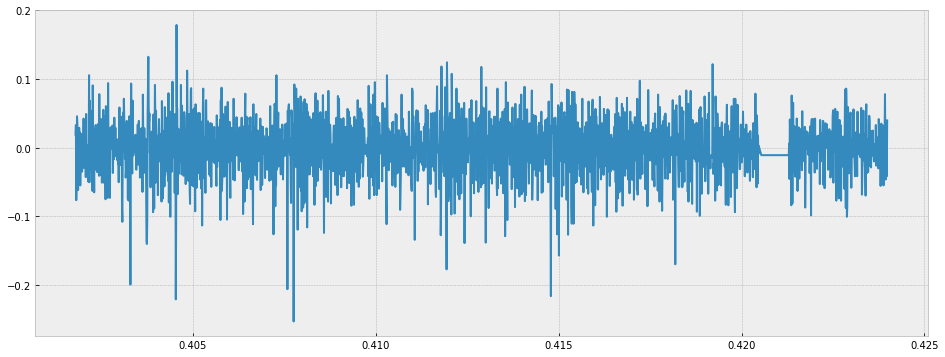

In [8]:
plt.plot(dates[1:], diff_norm_avg_temps)

### Úprava dat pro neuronovou síť
množina byla rozdělena na trénovací a validační v poměru 75%:25%

In [9]:
dataset = [(x, np.array([y])) for x, y in zip(diff_norm_inputs, diff_norm_avg_temps)]
random.shuffle(dataset)
dataset[0:5]

[(array([ 0.04224059, -0.0174472 , -0.00642792,  0.07116621,  0.        ]),
  array([-0.01813298])),
 (array([-0.11753903, -0.07162534,  0.00472397, -0.04591368,  0.00472397]),
  array([0.00873069])),
 (array([-0.14233242,  0.00183655,  0.        ,  0.84481175,  0.        ]),
  array([-0.03122901])),
 (array([-0.02938476, -0.01469238,  0.00734619,  0.05050505,  0.01836547]),
  array([-0.05104097])),
 (array([ 0.17263545, -0.01469238,  0.        , -0.03673095,  0.        ]),
  array([0.00335796]))]

In [10]:
training_data, test_data = NeuralNet.ratio_list_split(dataset, 0.75)
len(training_data), len(test_data), len(dataset), training_data[0]

(1599,
 534,
 2133,
 (array([ 0.04224059, -0.0174472 , -0.00642792,  0.07116621,  0.        ]),
  array([-0.01813298])))

## Vypracování

Příprava množiny hyperparametrů

In [11]:
neurons = [3, 5, 10, 50]
epochs = [True]
learning_rates = [0.5, 0.1, 0.05, 0.005]
max_epochs = 200
target_test_mse = 0.001

In [12]:
params = itertools.product(neurons, epochs, learning_rates)
stats = []
for p in params:
    test_mse_list = []
    train_mse_list = []
    nn = NeuralNet([len(dataset[0][0]), p[0], len(dataset[0][1])], a_functions=[af.tanh, af.tanh], a_functions_prime=[af.tanh_prime, af.tanh_prime])
    print(p)
    for e in nn.gradient_descent_testdata(
            labeled_training_dataset=training_data,
            labeled_test_dataset=test_data,
            no_epochs=p[1],
            mini_batch_size=128,
            learning_rate=p[2]
            ):
        print('epoch: ', e['epoch'], end='\r')
        test_mse_list.append(e['test mse'])
        train_mse_list.append(e['train mse'])
        if e['test mse'] < target_test_mse:
            result = {
                'success': True,
                'neurons input layer': nn.layer_sizes[0],
                'neurons hidden layer': p[0],
                'epochs': e['epoch'] + 1,
                'learning rate': p[2],
                'test mse list' : test_mse_list,
                'train mse list' : train_mse_list,
                    
            }
            stats.append(result)
            print()
            print('TARGET HIT epoch', e['epoch'], '\n test mse', e['test mse'],
                  '\n train mse', e['train mse'])
            print()
            break
        if e['epoch'] > max_epochs - 1: # last epoch
            result = {
                'success': False,
                'neurons input layer': nn.layer_sizes[0],
                'neurons hidden layer': p[0],
                'epochs': e['epoch'] + 1,
                'learning rate': p[2],
                'test mse list' : test_mse_list,
                'train mse list' : train_mse_list,
            }
            stats.append(result)
            print()
            print('TARGET NOT HIT epoch', e['epoch'], '\n test mse', e['test mse'],
                  '\n train mse', e['train mse'])
            print()
            break
stats_json = json.dumps(stats)
with open('resources/stats_avgtemp.json', 'w') as f:
    f.write(stats_json)

(3, True, 0.5)
epoch:  200
TARGET NOT HIT epoch 200 
 test mse 0.0012008097790070613 
 train mse 9.362901404400406e-06

(3, True, 0.1)
epoch:  200
TARGET NOT HIT epoch 200 
 test mse 0.0020712703270952134 
 train mse 1.6075633671463267e-05

(3, True, 0.05)
epoch:  200
TARGET NOT HIT epoch 200 
 test mse 0.001995691842135323 
 train mse 1.5771027640289893e-05

(3, True, 0.005)
epoch:  200
TARGET NOT HIT epoch 200 
 test mse 0.004111418215005452 
 train mse 3.0002954369637797e-05

(5, True, 0.5)
epoch:  200102
TARGET NOT HIT epoch 200 
 test mse 0.0011864012863707278 
 train mse 1.2127206026972974e-05

(5, True, 0.1)
epoch:  200
TARGET NOT HIT epoch 200 
 test mse 0.0015116135967505873 
 train mse 1.237000057576986e-05

(5, True, 0.05)
epoch:  200118
TARGET NOT HIT epoch 200 
 test mse 0.001769603080845378 
 train mse 1.4468875444265574e-05

(5, True, 0.005)
epoch:  200
TARGET NOT HIT epoch 200 
 test mse 0.0037766321628151943 
 train mse 3.86207576447209e-05

(10, True, 0.5)
epoch:  200

## Citlivostní analýza
tabulka hyperparametrů

In [13]:
df = pd.read_json('resources/stats_avgtemp.json')
df[['neurons input layer', 'neurons hidden layer', 'epochs', 'learning rate']]

,neurons input layer,neurons hidden layer,epochs,learning rate
0,5,3,201,0.500
1,5,3,201,0.100
2,5,3,201,0.050
3,5,3,201,0.005
4,5,5,201,0.500
5,5,5,201,0.100
6,5,5,201,0.050
7,5,5,201,0.005
8,5,10,201,0.500
9,5,10,201,0.100


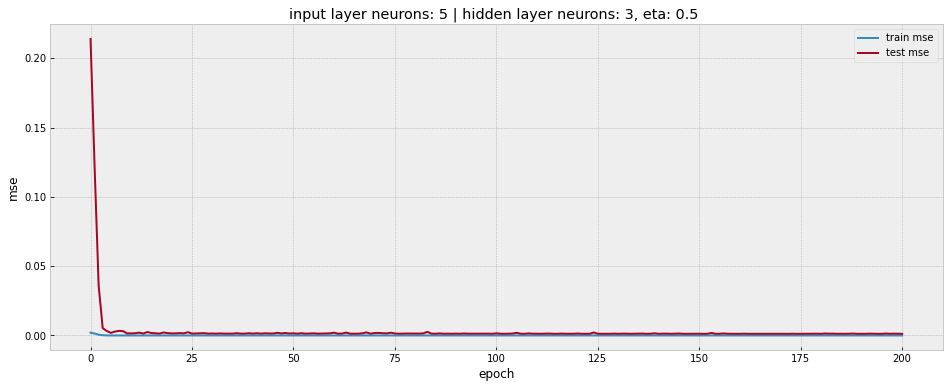

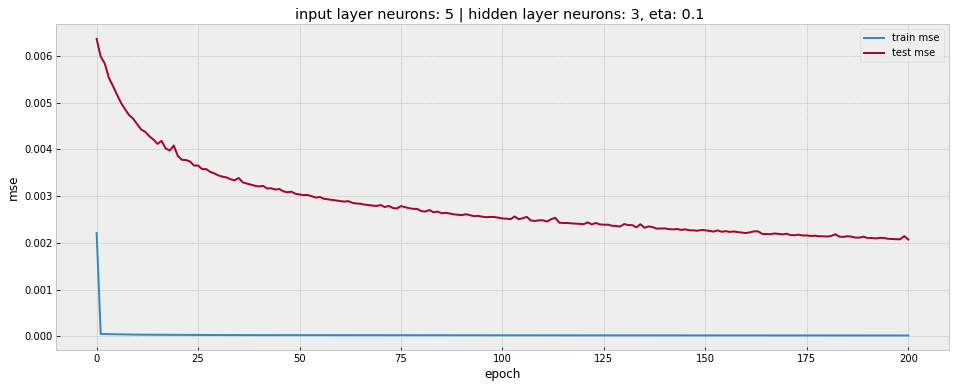

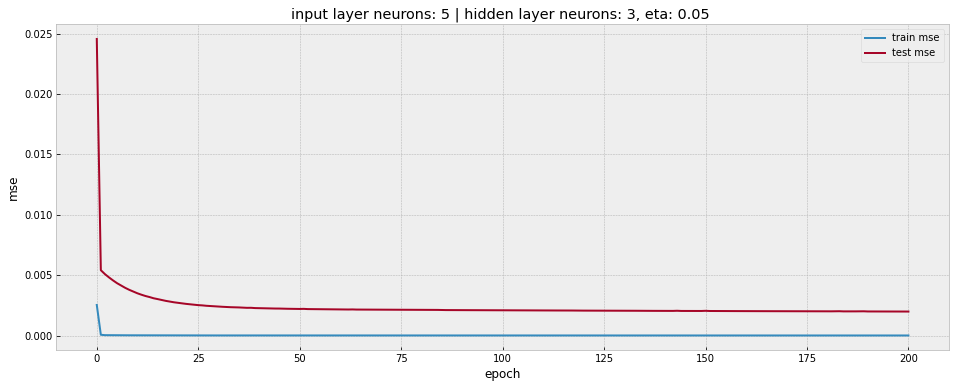

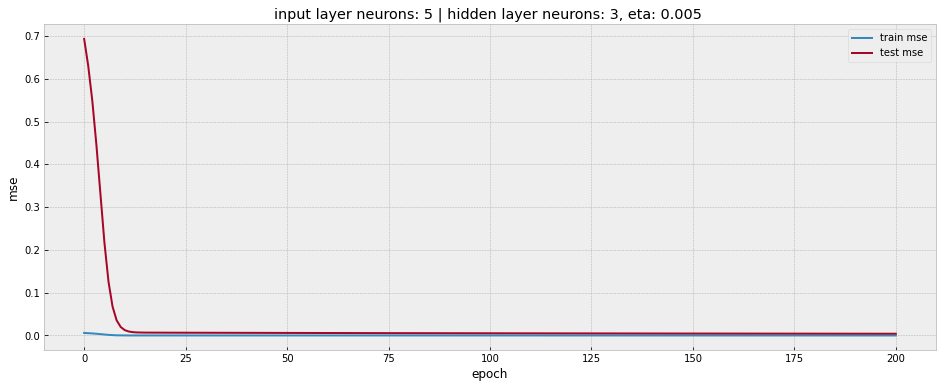

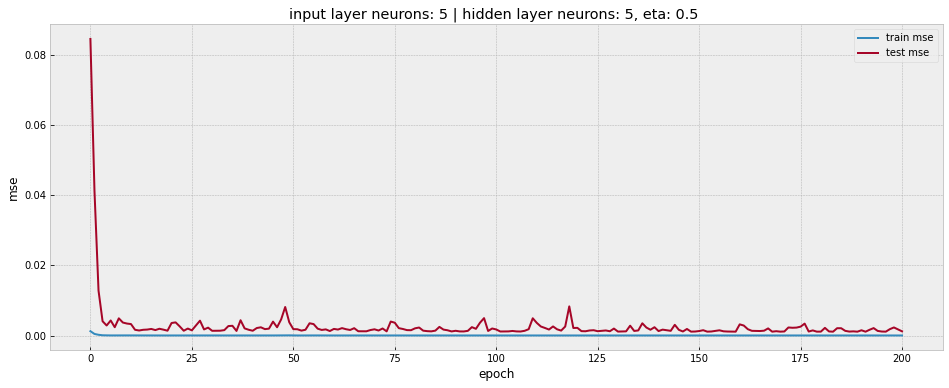

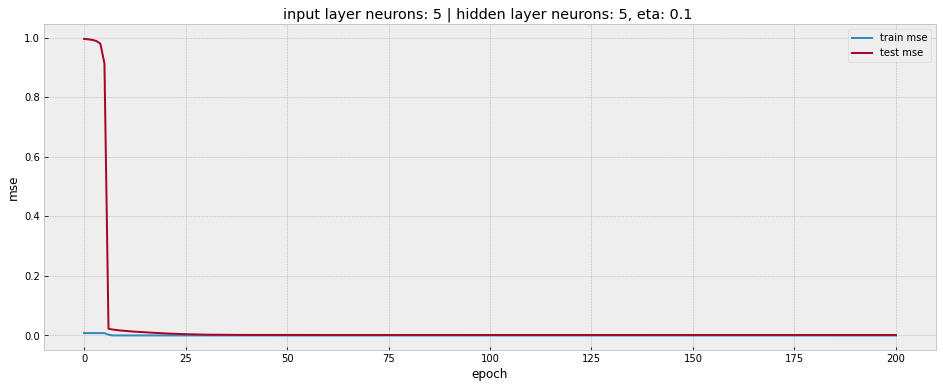

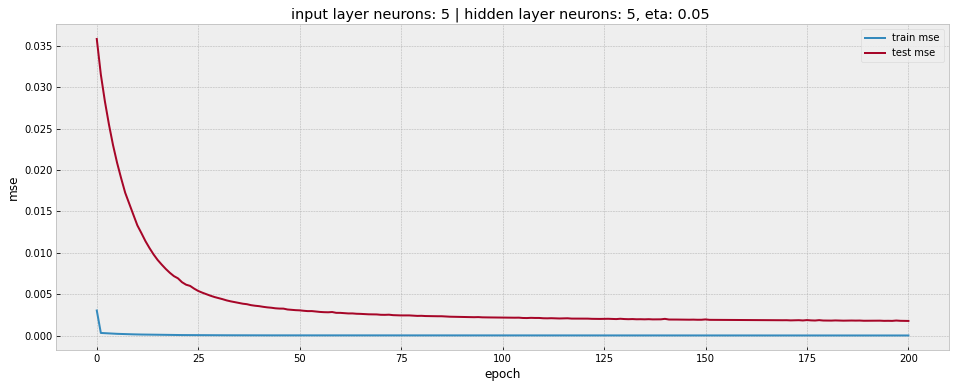

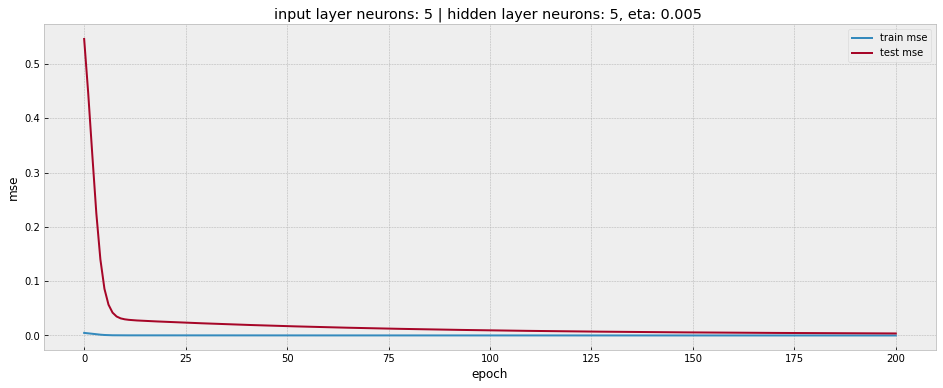

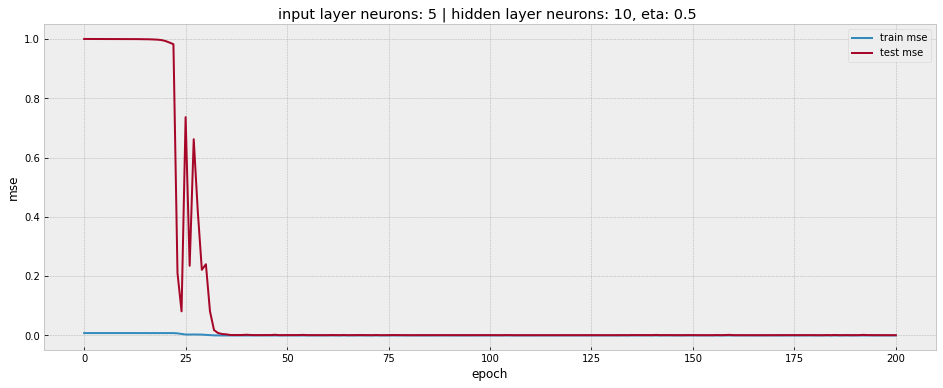

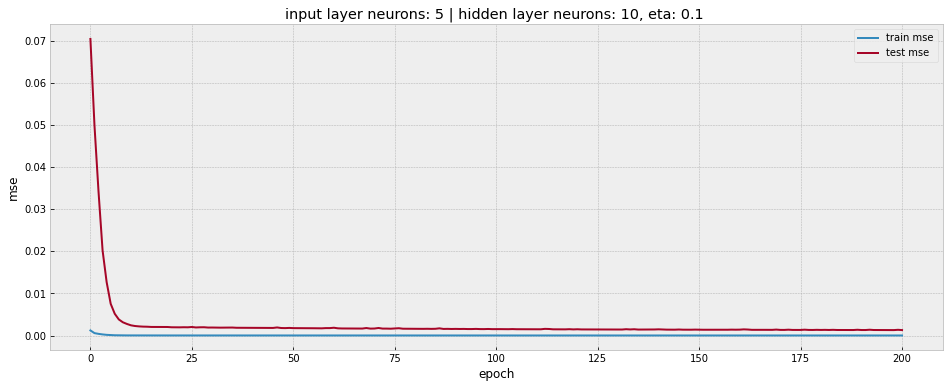

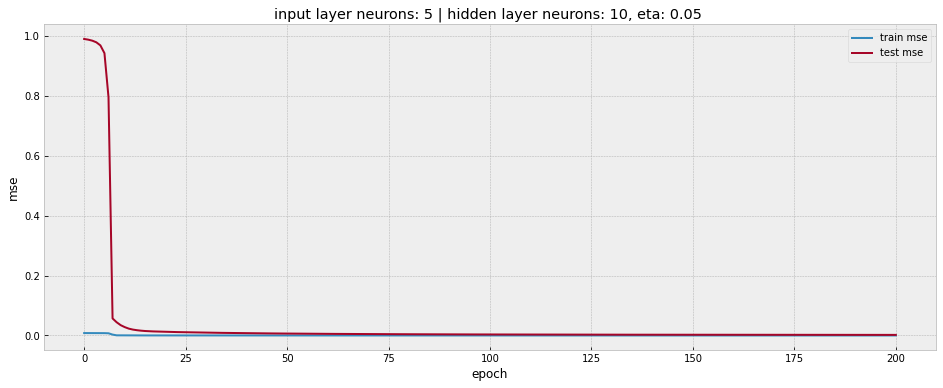

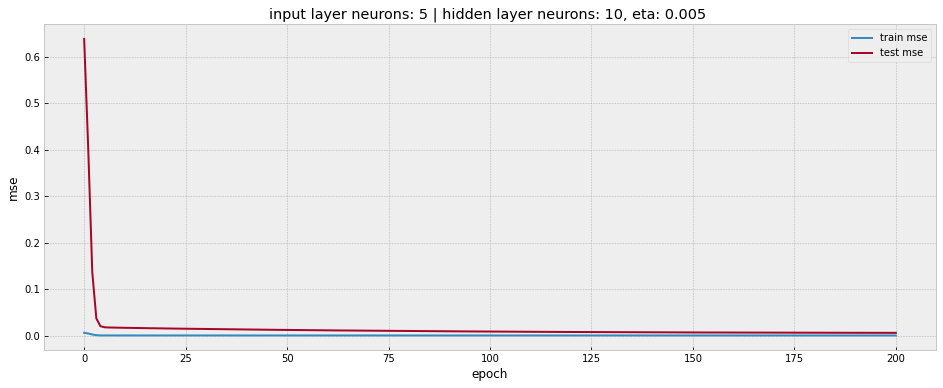

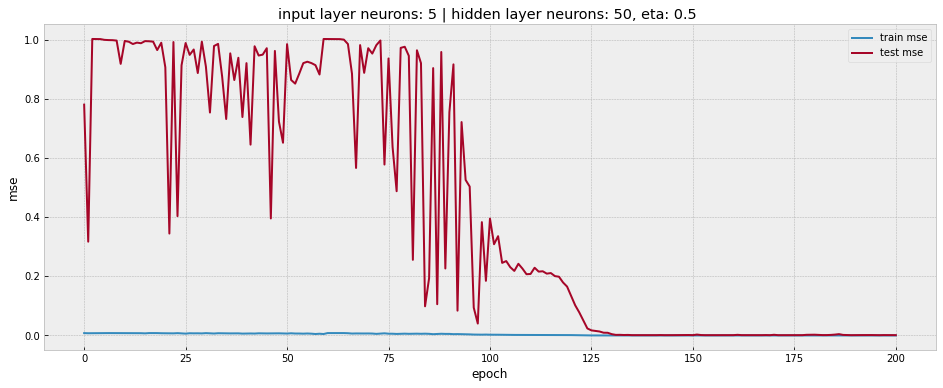

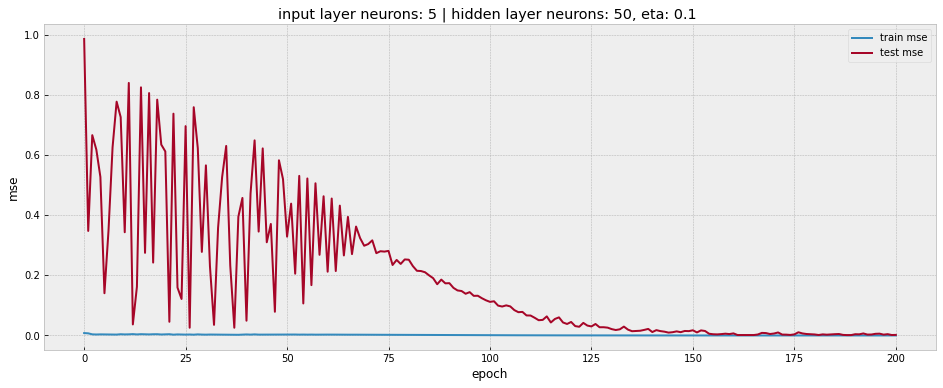

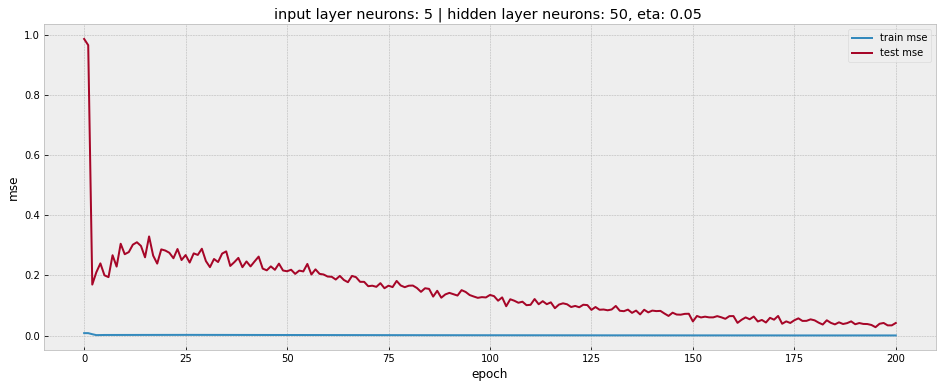

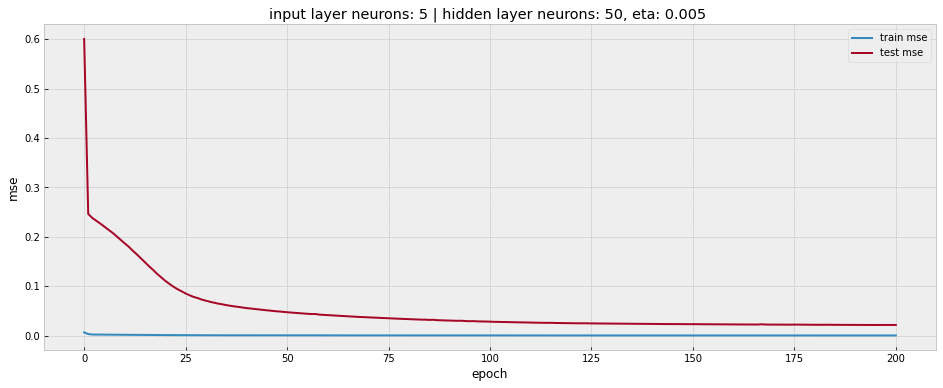

In [14]:

# fig.set_xlim([0,200])
# fig.set_ylim([0,0.05])

# plt.plot(df['mse list'], label='mse')
for i in range(15):
    plt.plot(df['train mse list'][i], label='train mse')
    plt.plot(df['test mse list'][i], label='test mse')
    plt.title('input layer neurons: {} | hidden layer neurons: {}, eta: {} '.format(df['neurons input layer'][i], df['neurons hidden layer'][i], df['learning rate'][i]))
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend()
    ax, fig = plt.subplots()
plt.plot(df['train mse list'][15], label='train mse')
plt.plot(df['test mse list'][15], label='test mse')
plt.title('input layer neurons: {} | hidden layer neurons: {}, eta: {} '.format(df['neurons input layer'][15], df['neurons hidden layer'][15], df['learning rate'][15]))
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()

In [11]:
neurons = [50]
epochs = [True]
learning_rates = [0.05]
max_epochs = 5000
target_test_mse = 0.01
params = itertools.product(neurons, epochs, learning_rates)
stats = []
for p in params:
    test_mse_list = []
    train_mse_list = []
    nn = NeuralNet([len(dataset[0][0]), p[0], len(dataset[0][1])], a_functions=[af.tanh, af.tanh], a_functions_prime=[af.tanh_prime, af.tanh_prime])
    print(p)
    for e in nn.gradient_descent_testdata(
            labeled_training_dataset=training_data,
            labeled_test_dataset=test_data,
            no_epochs=p[1],
            mini_batch_size=128,
            learning_rate=p[2]
            ):
        print('epoch: ', e['epoch'], end='\r')
        test_mse_list.append(e['test mse'])
        train_mse_list.append(e['train mse'])
        if e['test mse'] < target_test_mse:
            result = {
                'success': True,
                'neurons input layer': nn.layer_sizes[0],
                'neurons hidden layer': p[0],
                'epochs': e['epoch'] + 1,
                'learning rate': p[2],
                'test mse list' : test_mse_list,
                'train mse list' : train_mse_list,
                    
            }
            stats.append(result)
            print()
            print('TARGET HIT epoch', e['epoch'], '\n test mse', e['test mse'],
                  '\n train mse', e['train mse'])
            print()
            break
        if e['epoch'] > max_epochs - 1: # last epoch
            result = {
                'success': False,
                'neurons input layer': nn.layer_sizes[0],
                'neurons hidden layer': p[0],
                'epochs': e['epoch'] + 1,
                'learning rate': p[2],
                'test mse list' : test_mse_list,
                'train mse list' : train_mse_list,
            }
            stats.append(result)
            print()
            print('TARGET NOT HIT epoch', e['epoch'], '\n test mse', e['test mse'],
                  '\n train mse', e['train mse'])
            print()
            break
        if e['epoch'] % 100 == 0:
            print()
            print('intermediate result: epoch', e['epoch'], '\n test mse', e['test mse'],
                  '\n train mse', e['train mse'])
            print()
stats_json = json.dumps(stats)
with open('resources/stats_avgtemp_bestapprox_targetlower.json', 'w') as f:
    f.write(stats_json)

(50, True, 0.05)
epoch:  0
intermediate result: epoch 0 
 test mse 0.19829807912207578 
 train mse 0.0017396422683744622

epoch:  100
intermediate result: epoch 100 
 test mse 0.10065167502295176 
 train mse 0.0008593879879405362

epoch:  200
intermediate result: epoch 200 
 test mse 0.037374844905590586 
 train mse 0.00022805611767629137

epoch:  219
TARGET HIT epoch 219 
 test mse 0.0065786894433219984 
 train mse 0.00015729746513638607



## Predikce
Po vizuální inspekci průběhu vývoje test mse byly pro predikci vybrány hyperparamery:
- počet neuronů vstup: 4
- počet neuronů skrytá vrstva: 50
- learning rate 0.05

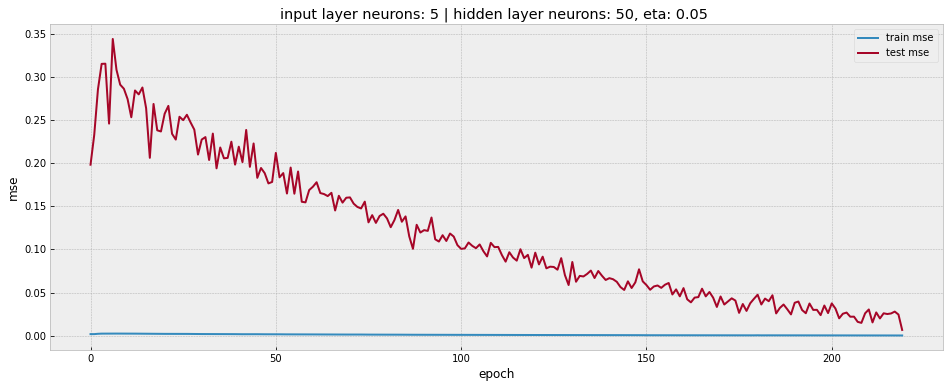

In [12]:
df = pd.read_json('resources/stats_avgtemp_bestapprox_targetlower.json')
ax, fig = plt.subplots()
# fig.set_ylim([0,0.02])
plt.plot(df['train mse list'][0], label='train mse')
plt.plot(df['test mse list'][0], label='test mse')
plt.title('input layer neurons: {} | hidden layer neurons: {}, eta: {} '.format(df['neurons input layer'][0], df['neurons hidden layer'][0], df['learning rate'][0]))
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()

In [19]:
prediction = [nn.feed_forward(x)['a'] for x in diff_norm_inputs]
prediction = np.array([x[0] for x in prediction])
prediction, len(prediction)

(array([-0.0820093 , -0.06500859, -0.12357382, ..., -0.04517385,
        -0.08289188, -0.04136453]),
 2133)

In [20]:
prediction

array([-0.0820093 , -0.06500859, -0.12357382, ..., -0.04517385,
       -0.08289188, -0.04136453])

In [25]:
prediction_undiff = np.concatenate((np.array([norm_avg_temps[0]]), prediction)).cumsum()
prediction_undiff

array([   0.9113499 ,    0.8293406 ,    0.76433201, ..., -140.77739914,
       -140.86029103, -140.90165556])

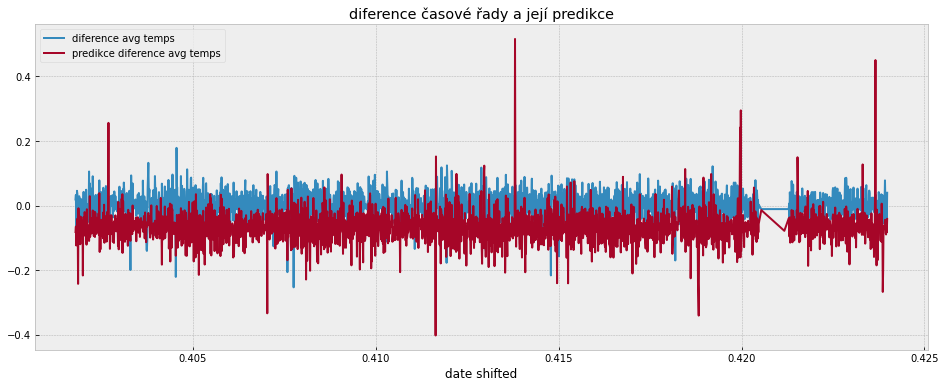

In [37]:
# plt.plot(dates, norm_avg_temps)
plt.plot(dates[1:], diff_norm_avg_temps, label='diference avg temps')
plt.plot(dates[1:], prediction, label='predikce diference avg temps')
plt.xlabel('date shifted')
plt.title("diference časové řady a její predikce")
plt.legend()

In [31]:
norm_avg_temps_undiff = np.concatenate((np.array([norm_avg_temps[0]]), diff_norm_avg_temps)).cumsum()
norm_avg_temps_undiff

array([0.9113499 , 0.93015447, 0.96306246, ..., 0.93485561, 0.89321692,
       0.93284083])

Ověření funkčnosti oddiferencování

In [32]:
np.array_equal(norm_avg_temps, norm_avg_temps_undiff)

True

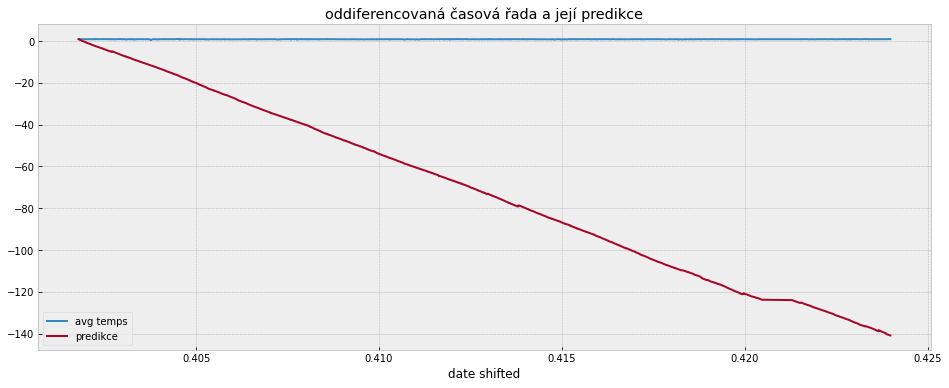

In [38]:
plt.plot(dates, undiff_norm_avg_temps, label='avg temps')
plt.plot(dates, prediction_undiff, label='predikce')
plt.xlabel('date shifted')
plt.title("oddiferencovaná časová řada a její predikce")
plt.legend()

## Závěr
Po vizuální inspekci diference v predikci byl nalezen posun na ose y do záporných hodnot, z čehož vyplývá velký klesající trend při predikci celé časové řady.